### Internal validation visualization

In [1]:
import os
import csv
import umap
import numpy as np
import pandas as pd
import matplotlib
from bokeh.plotting import figure, output_file, save, ColumnDataSource, show, output_notebook
from bokeh.models import CategoricalColorMapper, HoverTool
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from bokeh.io import export_svgs
from bokeh.layouts import gridplot
import numpy as np
from random import sample
import random

/data1/users/isotta/stratification_ILRM/myvenv/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data_folder_t1 = 'ehr-804370-test-1'
data_folder_t2 = 'ehr-804371-test-2'

In [3]:
DATA_PATH = os.path.expanduser('~/data1/ehr-stratification/data')

dm_file = 'patient-details.csv'
enc_file = 'encodings/convae-cut-{0}-avg_scaled.csv'

In [4]:
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['bisque', 'mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure',
         'beige', 'powderblue', 'floralwhite', 'ghostwhite', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
         'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
         'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen',
         'paleturquoise', 'palevioletred', 'papayawhip', 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue',
         'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray', 'ivory', 'whitesmoke']

In [19]:
def inner_viz(insp_dis, data_folder):
    print(data_folder)
    
    label = {'0':'Subtype I',
            '1':'Subtype II',
            '2':'Subtype III',
            '3':'Subtype IV',
            '4':'Subtype V'}
    scaler = MinMaxScaler()
    test = {}
    
    with open(os.path.join(DATA_PATH, 
                           data_folder,
                           'cohort-{0}-innerval-labels.csv'.format(insp_dis))) as f:
        rd = csv.reader(f)
        next(rd)
        mrn_subcl = {r[0]: int(r[1]) for r in rd}

    # subsample T2D for visualization purposes
    random.seed(1234)
    if insp_dis == 'T2D':
        mrn_sampl = sample(list(mrn_subcl.keys()), 5000)
    else:
        mrn_sampl = list(mrn_subcl.keys())
        
    with open(os.path.join(DATA_PATH, 
                           data_folder,
                           enc_file.format(insp_dis))) as f:
        rd = csv.reader(f)
        enc_data = {}
        test = {}
        for r in rd:
            if r[0] in mrn_subcl.keys() and r[0] in mrn_sampl:
                enc_data[r[0]] = r[1::]
                test[r[0]] = 'test1'

    mrn = list(enc_data.keys())
    data = np.array(list(enc_data.values())).astype(np.float64)
    convae_mtx = scaler.fit_transform(data)

    umap_tr = umap.UMAP(random_state=123, n_neighbors=10, min_dist=0.0)
    umap_mtx = umap_tr.fit_transform(convae_mtx)
    
    print(len(umap_mtx), umap_mtx.shape)

    df_dict = {'mrn': mrn, 
               'x': umap_mtx[:,0].tolist(), 
               'y': umap_mtx[:,1].tolist(), 
               'ds_class': [mrn_subcl[m] for m in mrn],
               'ts_group': [test[m] for m in mrn]}
    df = pd.DataFrame(df_dict).sort_values('ds_class')

    colormap = [c for c in col_dict if c not in c_out]
#     colormap_rid = [colormap[subc] for subc in sorted(list(set(df_dict['ds_class'])))]
#     colormap_rid = ['pink', 'deeppink', 'darkmagenta']#T2D
#     colormap_rid = ['tomato', 'firebrick', 'chocolate']#PD
#     colormap_rid = ['deepskyblue','darkcyan','seagreen']#AD
#     colormap_rid = ['darkviolet', 'dimgrey','royalblue', 'red']#MM2
#     colormap_rid = ['royalblue', 'darkviolet', 'crimson', 'maroon', 'dimgrey']#MM1
    colormap_rid = ['darkkhaki', 'orange']#BC
#     colormap_rid = ['purple', 'mediumvioletred', 'crimson']#PC
    scatter_plot(df, colormap_rid, insp_dis, label, data_folder)

#     # Dendrogram (for T2D rerun dendrogram with complete dataset not subsampled)
#     linked = linkage(convae_mtx, 'ward')
#     # Color mapping
#     dflt_col = "#808080"  # Unclustered gray
#     # * rows in Z correspond to "inverted U" links that connect clusters
#     # * rows are ordered by increasing distance
#     # * if the colors of the connected clusters match, use that color for link
#     link_cols = {}
#     for idx, lidx in enumerate(linked[:, :2].astype(int)):
#         c1, c2 = (link_cols[x] if x > len(linked) else colormap_rid[list(df_dict['ds_class'])[x]]
#                   for x in lidx)
#         link_cols[idx + 1 + len(linked)] = c1 if c1 == c2 else dflt_col

#     plt.figure(figsize=(10, 10))
#     dendrogram(Z=linked,
#                labels=['']*len(df),
#                color_threshold=None,
#                leaf_font_size=5, leaf_rotation=0,
#                link_color_func=lambda x: link_cols[x])
#     plt.savefig(os.path.join(DATA_PATH, data_folder, 
#                              '{0}-inner-val-dendrogram-test-{1}.eps'.format(insp_dis,
#                                                                      data_folder.split('-')[3])))
#     plt.show()

def scatter_plot(df, col, insp_dis, label, data_folder):
    source = ColumnDataSource(dict(
    x=df['x'].tolist(),
    y=df['y'].tolist(),
    mrn=df['mrn'].tolist(),
    ds_class=[label[str(i)] for i in df['ds_class'].tolist()],
    col_class = [str(i) for i in df['ds_class'].tolist()],
    ts_group=df['ts_group'].tolist()))

    labels = [str(i) for i in df['ds_class'].tolist()]
    cmap = CategoricalColorMapper(factors=sorted(pd.unique(labels)), palette=col)

    TOOLTIPS = [('mrn', '@mrn'),
                ('ds_class', '@ds_class'),
                ('ts_group', '@ts_group')]

    plotTools = 'box_zoom, wheel_zoom, pan,  crosshair, reset, save'

    output_notebook()
    p = figure(plot_width=400, plot_height=400, tools=plotTools, 
               title="Breast cancer")
    p.add_tools(HoverTool(tooltips=TOOLTIPS))
    p.circle('x', 'y', legend='ds_class', 
             source=source, color={"field": 'col_class', 
                                   "transform": cmap},
            size=5)
    p.xaxis.major_tick_line_color = None
    p.xaxis.minor_tick_line_color = None
    p.yaxis.major_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    p.xaxis.major_label_text_color = None
    p.yaxis.major_label_text_color = None
    p.grid.grid_line_color = None
    p.legend.location = 'top_left'
    p.title.align = 'center'

    show(p)
    p.output_backend = "svg"
    export_svgs(p, filename=os.path.join(DATA_PATH, data_folder, 
                             '{0}-subcluster-test-{1}.svg'.format(insp_dis,
                                                                  data_folder.split('-')[3])))
#     return p

In [118]:
inner_viz('T2D', data_folder_t2)

ehr-804371-test-2
5000 (5000, 2)


Loading BokehJS ...

In [8]:
inner_viz('PD', data_folder_t2)

ehr-804371-test-2
3071 (3071, 2)


Loading BokehJS ...

In [8]:
inner_viz('AD', data_folder_t2)

ehr-804371-test-2
3150 (3150, 2)


Loading BokehJS ...

In [14]:
inner_viz('MM', data_folder_t2)

ehr-804371-test-2
1883 (1883, 2)


Loading BokehJS ...

In [20]:
inner_viz('BC', data_folder_t2)

ehr-804371-test-2
7838 (7838, 2)


Loading BokehJS ...

In [18]:
inner_viz('PC', data_folder_t2)

ehr-804371-test-2
8645 (8645, 2)


Loading BokehJS ...

### Test 2 dataset

In [ ]:
inner_viz('T2D', data_folder_t2)

ehr-804371-test-2
3071 (3071, 2)


Loading BokehJS ...

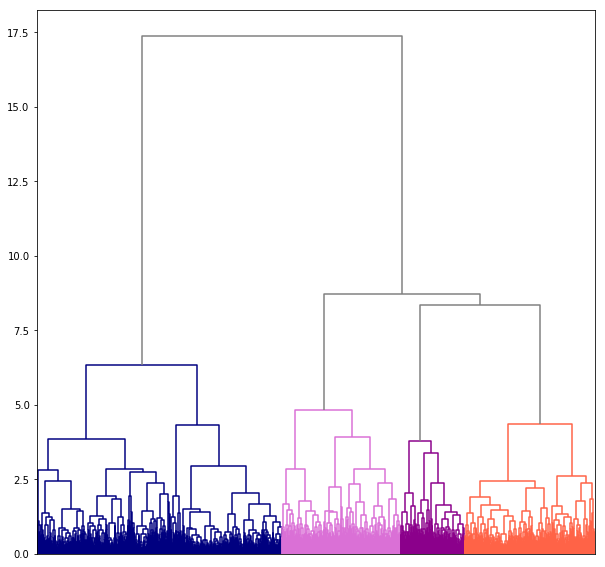

In [31]:
inner_viz('PD', data_folder_t2)

ehr-804371-test-2
3150 (3150, 2)


Loading BokehJS ...

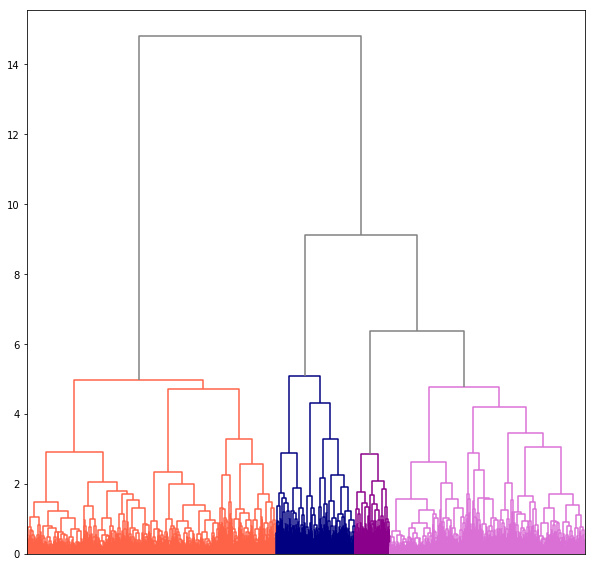

In [32]:
inner_viz('AD', data_folder_t2)

ehr-804371-test-2
1883 (1883, 2)


Loading BokehJS ...

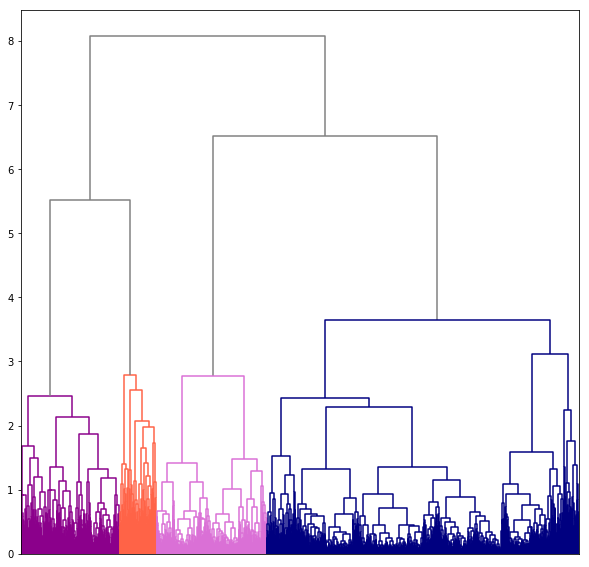

In [33]:
inner_viz('MM', data_folder_t2)